<a href="https://colab.research.google.com/github/jisusP/Articulo/blob/main/molecula_xyz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install rdkit

In [15]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import numpy as np
import pandas as pd
import glob

# Leer el archivo XYZ
with open('quinolina1.xyz', 'r') as f:
    xyz_data = f.read()
#Parte el archivo por líneas
lineas = xyz_data.splitlines()
#Obtiene una lista por cada línea; cada elemento es dado por la separación de espacios en el archivo
valores = [cadena.split() for cadena in lineas]
#Eliminamos todos los espacios que haya
valores_limpios = [elemento for elemento in valores if elemento]

#print(valores_limpios)

#esto sólo es para probar si la molécula se está leyendo
molecule = AllChem.MolFromXYZBlock(xyz_data)

# Asegurarse de que la molécula se ha creado correctamente
if molecule is None:
    print('Error al crear la molécula')
else:
    print('Molécula creada correctamente')

#Draw.MolToImageFile(molecule, "prueba.png")
print(valores_limpios)
#Creamos un diccionario para guardar por orden las listas que se obtienen de valores_limpios
indices = {}
for i,j in enumerate(valores_limpios[1:]):
  indices[i] = j
print(indices)
print("")

#Abrir el documento con las cargas
with open('Mulliken_1(1).txt', 'r') as f:
    texto = f.read()
#los parte por líneas
lineas = texto.split('\n')
#Elimina el título y la carga neta
del lineas[0]
del lineas[-1]
print(lineas)
#esto lo parte por espacios
filas = [linea.split() for linea in lineas]
print(filas)
#Hacemos lo mismo pero para las cargas...
cargas_Mulli ={}

for id, columnas in enumerate(filas):
  for conteo, dato in enumerate(columnas):
    i=0
    if dato == "NetCharge:":
      i=conteo
      intermediario = columnas[i+1]
  cargas_Mulli[id]=intermediario
print(cargas_Mulli)

Molécula creada correctamente
[['32'], ['C', '-3.655704', '-0.073700', '-0.293774'], ['C', '-3.094159', '-1.381731', '-0.293170'], ['C', '-1.742381', '-1.580333', '-0.230713'], ['C', '-0.857499', '-0.472013', '-0.160784'], ['C', '-1.405560', '0.836566', '-0.159693'], ['C', '-2.811116', '1.006506', '-0.226961'], ['N', '0.480286', '-0.704623', '-0.099633'], ['C', '1.297227', '0.323206', '-0.036357'], ['C', '0.846132', '1.672003', '-0.029942'], ['C', '-0.495173', '1.920026', '-0.091683'], ['C', '2.760398', '0.029647', '0.031401'], ['N', '3.583943', '1.082013', '0.088057'], ['C', '4.894264', '0.851744', '0.149591'], ['C', '5.450661', '-0.422709', '0.158116'], ['C', '4.590789', '-1.513242', '0.098998'], ['C', '3.223747', '-1.287888', '0.034528'], ['C', '-5.153942', '0.088952', '-0.321539'], ['C', '-5.782163', '-0.231154', '1.039302'], ['H', '-3.761919', '-2.236299', '-0.350179'], ['H', '-1.313677', '-2.576024', '-0.236020'], ['H', '-3.214057', '2.015681', '-0.226391'], ['H', '1.574275', '2.

In [ ]:
#Cremaos la matriz
barysz_matrix = np.zeros((len(valores_limpios)-1, len(valores_limpios)-1))
enlaces = []
#Se recorre el diccionario 2 veces
for id, valor in indices.items():
  for id2, valor2 in indices.items():
    #Se obtiene la distancia de todas las coordenadas
    d_val = np.sqrt((float(valor[1])-float(valor2[1]))**2 + (float(valor[2])-float(valor2[2]))**2 + (float(valor[3])-float(valor2[3]))**2)
    #Para guardarnos en salud, si la distancia es 0, es porque son los mismos, y nos interesa son las parejas distintas
    if d_val!=0:
      # En este condicional se deben de poner todas las directrices para validar a un enlace (en este caso sólo se tomó en cuenta la distancia...)
      #(... de enlace en amnstrong)
      if d_val <= 1.5:
        d_AB=0
        # Ahora se recorre desde el 2do valor de la lista (las coordenadas)
        for i in range(1,len(valor2)-1):
          #Para hallar la distancia al cuadrado
          d_AB += (float(valor[i])- float(valor2[i]))**2

        d_AB_raiz = np.sqrt(d_AB)


        #Se procede a llenar la matriz a través del producto de cargas sobre la distancia al cuadrado
        barysz_matrix[id, id2] = (float(cargas_Mulli[id])*float(cargas_Mulli[id2]))/d_AB
        barysz_matrix[id2, id] = (float(cargas_Mulli[id])*float(cargas_Mulli[id2]))/d_AB


print(barysz_matrix)

[[ 0.         -0.01334276  0.         ...  0.          0.
   0.        ]
 [-0.01334276  0.          0.01727052 ...  0.          0.
   0.        ]
 [ 0.          0.01727052  0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [ ]:
#Creamos una función que recibe una matriz para hallarle algún tipo de descriptor
#En este caso "randic", sin embargo, sólo utilizamos su expresión matemática, más no su lógica de conectividad...
#Ya que en lo que debería estar los grados de conectividad está la sumatoria de las fuerzas por cada 2 nodos
def randic(matriz):
  #Se obtiene el número de átomos del archivo .xyz (primera línea)
  N_atoms = int(valores_limpios[0][0])
  Grado_conectividad = np.sum(matriz, axis=1)
  randic = 0
  #Se recorre la matriz hasta el número de átomos que haya
  for i in range(N_atoms):
    for j in range(i+1, N_atoms):
      #Condiciones para que no haya indeterminación al momento de dividir
      if matriz[i, j] != 0 and Grado_conectividad[i] != 0 and Grado_conectividad[j] != 0:
        producto = Grado_conectividad[i] * Grado_conectividad[j]
        #Condiciones de valor absoluto
        if producto >= 0:
          randic += 1 /(producto)**0.5
        else:
          randic += 1/(-producto)**0.5
  return randic

randic_L=[]
randic_L.append(randic(barysz_matrix))
randic_L


[1407.3623623347441]

In [20]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import numpy as np
import pandas as pd
import glob
from natsort import natsorted

def leer(xyz, carga_txt):
  with open(xyz, 'r') as f:
      xyz_data = f.read()
  lineas = xyz_data.splitlines()
  valores = [cadena.split() for cadena in lineas]
  valores_limpios = [elemento for elemento in valores if elemento]
  """
  molecule = AllChem.MolFromXYZBlock(xyz_data)
  if molecule is None:
      print('Error al crear la molécula')
  else:
      print('Molécula creada correctamente')
  """
  indices = {}
  for i,j in enumerate(valores_limpios[1:]):
    indices[i] = j
  with open(carga_txt, 'r') as f:
      texto = f.read()
  lineas = texto.split('\n')
  del lineas[0]
  del lineas[-1]
  filas = [linea.split() for linea in lineas]
  cargas_Mulli ={}
  for id, columnas in enumerate(filas):
    intermediario=[]
    for conteo, dato in enumerate(columnas):
      i=0
      if dato == "NetCharge:":
        i=conteo
        intermediario = columnas[i+1]
    cargas_Mulli[id]=intermediario

  barysz_matrix = np.zeros((len(valores_limpios)-1, len(valores_limpios)-1))
  enlaces = []
  for id, valor in indices.items():
    for id2, valor2 in indices.items():
      d_val = np.sqrt((float(valor[1])-float(valor2[1]))**2 + (float(valor[2])-float(valor2[2]))**2 + (float(valor[3])-float(valor2[3]))**2)
      if d_val!=0:
        if d_val <= 1.5:
          d_AB=0
          for i in range(1,len(valor2)-1):
            d_AB += (float(valor[i])- float(valor2[i]))**2
          d_AB_raiz = np.sqrt(d_AB)
          barysz_matrix[id, id2] = (float(cargas_Mulli[id]) * float(cargas_Mulli[id2])) / d_AB
          barysz_matrix[id2, id] = (float(cargas_Mulli[id]) * float(cargas_Mulli[id2])) / d_AB

  N_atoms = int(valores_limpios[0][0])
  Grado_conectividad = np.sum(barysz_matrix, axis=1)
  randic = 0
  for i in range(N_atoms):
    for j in range(i+1, N_atoms):
      if barysz_matrix[i, j] != 0 and Grado_conectividad[i] != 0 and Grado_conectividad[j] != 0:
        producto = Grado_conectividad[i] * Grado_conectividad[j]
        if producto >= 0:
          randic += 1 /(producto)**0.5
        else:
          randic += 1/(-producto)**0.5

  return randic #También podríamos ver: indices, cargas_Mulli, barysz_matrix,


# Ruta del directorio
directorio = "/content/"

patron_txt = "*.txt"
patron_xyz = "*.xyz"

dicc_randic={}
# Lista de archivos .txt y .xyz en el directorio
archivos_txt = natsorted(glob.glob(directorio + patron_txt))
archivos_xyz = natsorted(glob.glob(directorio + patron_xyz))
#print(archivos_txt, archivos_xyz)

#Glob.glob da una lista de todos los archivos con ese patrón en el directorio
#sorted ordena la lista alfanuméricamente (a1, a10, a11, a2,...)
#natsorted: ordena de manera natural (a1, a2, a3,..., a10, a11,...)

# Verificar que haya la misma cantidad de archivos .txt y .xyz
if len(archivos_txt) == len(archivos_xyz):
    c=1
    for archivo_txt, archivo_xyz in zip(archivos_txt, archivos_xyz):
        dicc_randic[c] = [leer(archivo_xyz, archivo_txt)]
        c+=1

else:
    print("Cantidad de archivos .txt y .xyz impares.")

print(dicc_randic)
print(dicc_randic.items())


{1: [1407.3623623347441]}
dict_items([(1, [1407.3623623347441])])


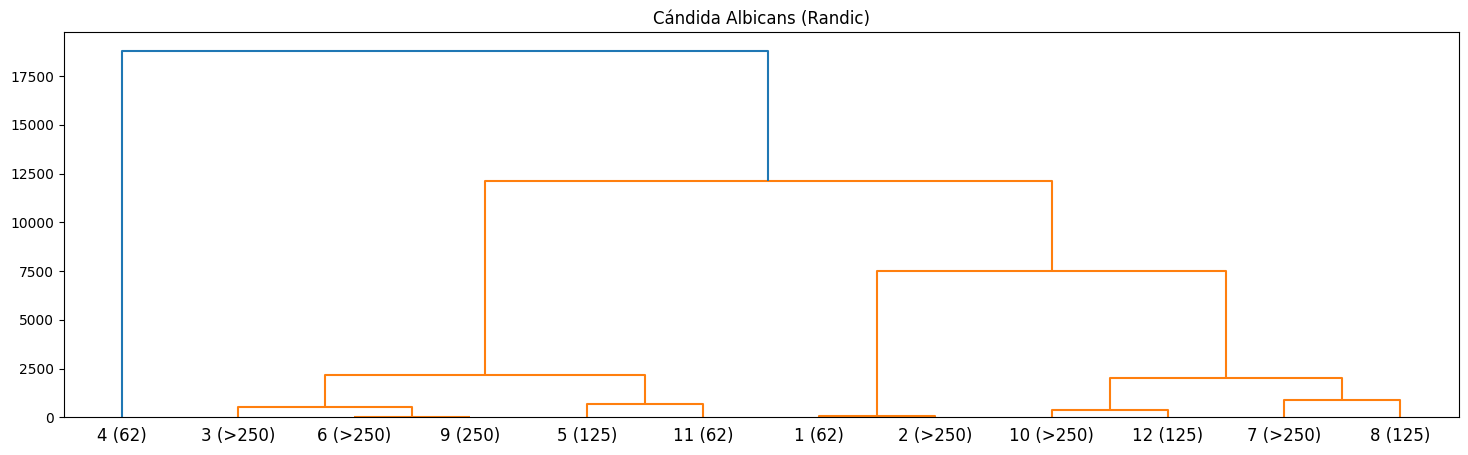

In [ ]:
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
import numpy as np

r_index = []
for id, r in dicc_randic.items():
    r_index.append(r[0])

def randic_similarity(ri1, ri2):
    return 1 - abs(ri1 - ri2)

similarity_matrix = [[randic_similarity(ri1, ri2) for ri2 in r_index] for ri1 in r_index]
distance_matrix = [[1 - randic_similarity(ri1, ri2) for ri2 in r_index] for ri1 in r_index]

lab = ["1 (62)","2 (>250)","3 (>250)","4 (62)","5 (125)","6 (>250)","7 (>250)","8 (125)","9 (250)","10 (>250)","11 (62)","12 (125)"] #
plt.figure(figsize=(18,5))
plt.title("Cándida Albicans (Randic)")
d = shc.dendrogram(shc.linkage(similarity_matrix, method = "ward"), labels = lab)


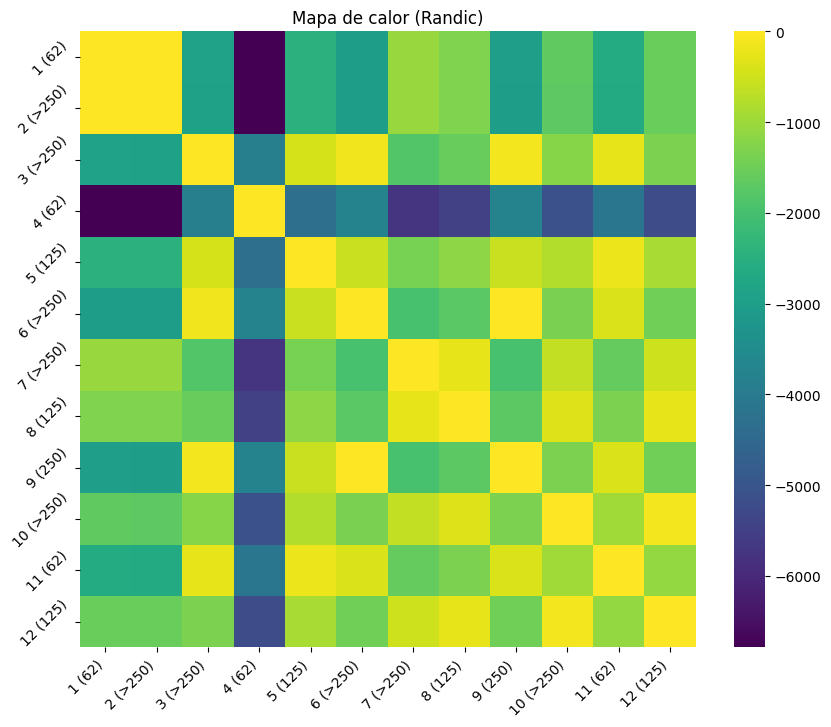

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=False, cbar=True, square=True, cmap='viridis')
plt.xticks(np.arange(len(lab)) + 0.5, lab, rotation=45, ha='right')
plt.yticks(np.arange(len(lab)) + 0.5, lab, rotation=45, ha='right')
# Configurar el aspecto del heatmap
plt.title("Mapa de calor (Randic)")
plt.xlabel
plt.ylabel

# Mostrar el heatmap
plt.show()